# Import Libraries needed to run notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# I. Read in Data

In [2]:
# Define optimal nm for 12 point spectrum
nm_optimal = [680, 700, 730, 760, 800, 850]
nm_optimal

[680, 700, 730, 760, 800, 850]

## Hb

In [3]:
# Read in Hb dat, filtering on nms of choice
Hb_dat = pd.read_csv(r'Hb.csv')
Hb_dat = Hb_dat.loc[Hb_dat['nm'].isin(nm_optimal)].copy()
Hb_dat['signal'] = [int(x.split(';')[1]) for x in Hb_dat['var1']]

# Save max signal for normalization purposes
max_signal = np.max(Hb_dat['signal'])
Hb_dat['signal'] = Hb_dat['signal']/max_signal
Hb_dat

,nm,var1,var2,signal
20,680,0000;2547,1957,1.000000
40,700,0000;1803,9736,0.707892
70,730,0000;1148,2775,0.450726
100,760,0000;1525,3238,0.598744
140,800,0000;778,2100,0.305457
190,850,0000;683,2000,0.268159


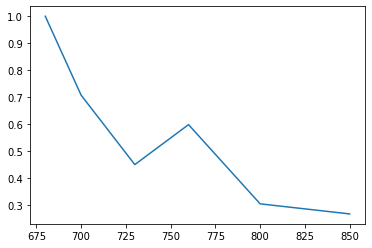

In [4]:
plt.plot(Hb_dat['nm'], Hb_dat['signal'])

In [5]:
# Read in HbO2 dat
HbO2_dat = pd.read_csv(r'HbO2.csv')
HbO2_dat = HbO2_dat.loc[HbO2_dat['nm'].isin(nm_optimal)].copy()
HbO2_dat['signal'] = [int(x.split(';')[1]) for x in HbO2_dat['var1']]
HbO2_dat['signal'] = HbO2_dat['signal']/max_signal
HbO2_dat

,nm,var1,var2,signal
20,680,0000;268,6262,0.105222
40,700,0000;285,5616,0.111896
70,730,0000;386,4001,0.151551
100,760,0000;592,7210,0.232430
140,800,0000;796,9595,0.312525
190,850,0000;1055,1370,0.414213


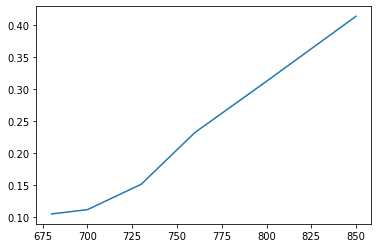

In [6]:
plt.plot(HbO2_dat['nm'], HbO2_dat['signal'])

### x values in spectrum (frequencies)

In [7]:
# Define x values
x = Hb_dat['nm'].values
x

array([680, 700, 730, 760, 800, 850], dtype=int64)

### number of fractional components

In [8]:
# Number of fractional components - rows in simulated dataset
fractional_components = np.linspace(0, 1, 1001)
fractional_components

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

### Function to create simulated dataset

In [9]:
# Function to create simulated dataset
def create_simulated_dataset(fractions, func_1, func_2, noise_sd):
    
    # Initialize list to hold dataset
    dat = []
    
    # Loop through to create dataset
    for fraction in fractions:
    
        # Define fractional components for each function
        function_1_fraction = fraction
        function_2_fraction = np.round(1 - fraction,2)
    
        # Multiply signal values by fraction
        func_1_fraction = func_1*function_1_fraction
        func_2_fraction = func_2*function_2_fraction
    
        # Add fractional signals together
        y_sum_fraction = func_1_fraction + func_2_fraction
        
        # Add random white gaussian noise to summed-spectrum
        noise = np.random.normal(0,noise_sd,len(y_sum_fraction))
        y_sum_fraction = y_sum_fraction + noise
    
        # Append result
        dat.append([function_1_fraction,
                    function_2_fraction] + list(y_sum_fraction))

    # Convert to dataframe
    dat = pd.DataFrame(dat,
                       columns = ['y1', 'y2',
                                  'x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
    
    # Return dataset
    return(dat)

# II. spectral unmixing

In [10]:
# Create example dataset - no noise
simulated_dataset = create_simulated_dataset(fractional_components, 
                                             Hb_dat['signal'].values, 
                                             HbO2_dat['signal'].values, 
                                             0)
simulated_dataset

,y1,y2,x1,x2,x3,x4,x5,x6
0,0.000,1.0,0.105222,0.111896,0.151551,0.232430,0.312525,0.414213
1,0.001,1.0,0.106222,0.112604,0.152002,0.233029,0.312830,0.414481
2,0.002,1.0,0.107222,0.113312,0.152452,0.233628,0.313135,0.414749
3,0.003,1.0,0.108222,0.114020,0.152903,0.234227,0.313441,0.415017
4,0.004,1.0,0.109222,0.114728,0.153354,0.234825,0.313746,0.415285
...,...,...,...,...,...,...,...,...
996,0.996,0.0,0.996000,0.705060,0.448923,0.596349,0.304236,0.267086
997,0.997,0.0,0.997000,0.705768,0.449374,0.596947,0.304541,0.267354
998,0.998,0.0,0.998000,0.706476,0.449825,0.597546,0.304846,0.267622
999,0.999,0.0,0.999000,0.707184,0.450276,0.598145,0.305152,0.267890


## a) basic concept on single spectrum

### create X --> 100% Hb and 100% HbO<sub>2</sub> msot spectra

In [11]:
# Define X
y1_100 = np.squeeze(simulated_dataset.iloc[len(simulated_dataset)-1,
                                           2:].to_numpy())
y2_100 = np.squeeze(simulated_dataset.iloc[0,
                                           2:].to_numpy())

X = np.array([y1_100, y2_100]).T
X

array([[1.        , 0.10522183],
       [0.70789164, 0.11189635],
       [0.45072634, 0.15155084],
       [0.59874362, 0.23243031],
       [0.3054574 , 0.31252454],
       [0.26815862, 0.4142128 ]])

### create y --> msot spectra at user defined fractional components

In [12]:
# User defined y signal at given y1, y2 fractional components
y1_frac = 0.1 # User defined
dat_temp = simulated_dataset.loc[simulated_dataset['y1']==y1_frac].copy()
y = np.squeeze(dat_temp.iloc[:,2:].to_numpy())
y

array([0.19469965, 0.17149588, 0.18146839, 0.26906164, 0.31181782,
       0.39960738])

### estimate fractional components of y using spectral unmixing

In [13]:
# Use spectral unmixing to get fractional components
linear_regressor = LinearRegression(fit_intercept=False)
linear_regressor.fit(X, y)

# Estimated fractional components (y1_frac, y2_frac)
y1_estimate, y2_estimate = linear_regressor.coef_

print('y1 estimate: ' + str(np.round(y1_estimate,2)))
print('y2 estimate: ' + str(np.round(y2_estimate,2)))

y1 estimate: 0.1
y2 estimate: 0.9


### estimated components of y1 and y2 in msot spectrum

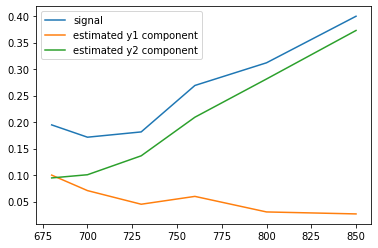

In [14]:
# Plot
plt.plot(x, y, label = "signal") # Raw Signal

# y signals for each components based on regression estimates
## y1
y1_frac = y1_estimate
y1_signal = Hb_dat['signal'].values*y1_frac
plt.plot(x, y1_signal, label = "estimated y1 component")
## y2
y2_frac = y2_estimate
y2_signal = HbO2_dat['signal'].values*y2_frac
plt.plot(x, y2_signal, label = "estimated y2 component")

# Plot
plt.legend()
plt.show()

## b) calculate rmse of estimates on all spectra in dataset

In [15]:
# Define actual y1s and y2s
y1s = list(simulated_dataset['y1'].values)
y2s = list(simulated_dataset['y2'].values)

# Preallocate lists to hold y1 and y2 estimates
y1_estimates = []
y2_estimates = []

# Define linear regressor
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

# Loop through each spectrum and estimate y1 and y2 using spectral unmixing
for spectrum_iterator in range(len(simulated_dataset)):
    y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                          2:].to_numpy())
    # Use spectral unmixing to get fractional components
    linear_regressor.fit(X, y)

    # Estimated fractional components (y1_frac, y2_frac)
    y1_estimate, y2_estimate = linear_regressor.coef_
    
    # Append results
    y1_estimates.append(y1_estimate)
    y2_estimates.append(y2_estimate)
    
# Calculate rmse for y1 and y2
rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                             squared=False)
print('rmse_y1: ' + str(rmse_y1))
rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                             squared=False)
print('rmse_y2: ' + str(rmse_y2))

rmse_y1: 2.0028413308357474e-16
rmse_y2: 2.0190568170149667e-16


In [16]:
# Calculate average rmse
avg_rmse = (rmse_y1 + rmse_y2)/2
print('average rmse: ' + str(avg_rmse))

average rmse: 2.010949073925357e-16


## c) full simulated experiment

In [17]:
# Initialize result array
results = []

# Define linear regressor
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

# Define noise levels
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
for noise_level in noise_levels:
    
    # Define number of repetitions
    reps = np.linspace(1, 100, 100)
    for rep in reps:
        
        # Create simulated dataset
        simulated_dataset = create_simulated_dataset(fractional_components, 
                                                     Hb_dat['signal'].values, 
                                                     HbO2_dat['signal'].values, 
                                                     noise_level)
        
        # Define actual y1s and y2s
        y1s = list(simulated_dataset['y1'].values)
        y2s = list(simulated_dataset['y2'].values)

        # Preallocate lists to hold y1 and y2 estimates
        y1_estimates = []
        y2_estimates = []

        # Loop through each spectrum and estimate y1 and y2 using spectral unmixing
        for spectrum_iterator in range(len(simulated_dataset)):
            y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                                  2:].to_numpy())
            # Use spectral unmixing to get fractional components
            linear_regressor.fit(X, y)

            # Estimated fractional components (y1_frac, y2_frac)
            y1_estimate, y2_estimate = linear_regressor.coef_
    
            # Append results
            y1_estimates.append(y1_estimate)
            y2_estimates.append(y2_estimate)
    
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
            
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
            
        # Append results
        results.append([noise_level, rep, avg_rmse])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse'])
results

,noise_level,rep,avg_rmse
0,0.0,1.0,2.010949e-16
1,0.0,2.0,2.010949e-16
2,0.0,3.0,2.010949e-16
3,0.0,4.0,2.010949e-16
4,0.0,5.0,2.010949e-16
...,...,...,...
495,0.2,96.0,2.719009e-01
496,0.2,97.0,2.626615e-01
497,0.2,98.0,2.663371e-01
498,0.2,99.0,2.668350e-01


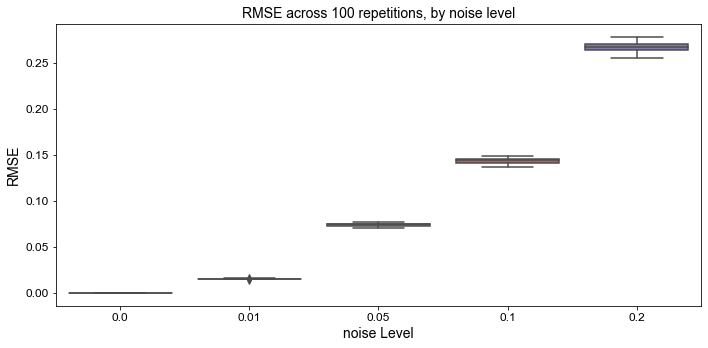

In [18]:
# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("RMSE",
              fontsize=14)
ax.set_title("RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

# III. machine learning

In [19]:
# Create X - no noise for training
simulated_dataset = create_simulated_dataset(fractional_components, 
                                             Hb_dat['signal'].values, 
                                             HbO2_dat['signal'].values, 
                                             0)
X = simulated_dataset.iloc[:, 2:].values
X

array([[0.10522183, 0.11189635, 0.15155084, 0.23243031, 0.31252454,
        0.4142128 ],
       [0.10622183, 0.11260424, 0.15200157, 0.23302905, 0.31283   ,
        0.41448096],
       [0.10722183, 0.11331213, 0.1524523 , 0.2336278 , 0.31313545,
        0.41474912],
       ...,
       [0.998     , 0.70647585, 0.44982489, 0.59754613, 0.30484649,
        0.2676223 ],
       [0.999     , 0.70718375, 0.45027562, 0.59814488, 0.30515194,
        0.26789046],
       [1.        , 0.70789164, 0.45072634, 0.59874362, 0.3054574 ,
        0.26815862]])

In [20]:
# Create y
y = simulated_dataset.iloc[:, 0:2].values
y

array([[0.   , 1.   ],
       [0.001, 1.   ],
       [0.002, 1.   ],
       ...,
       [0.998, 0.   ],
       [0.999, 0.   ],
       [1.   , 0.   ]])

## a) Ridge Regression

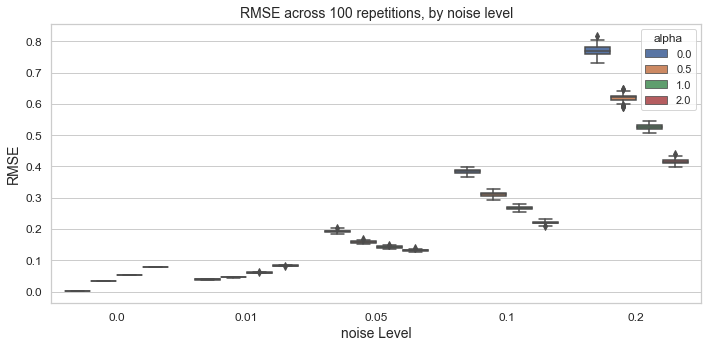

In [21]:
# Initialize result array
results = []

# Define alphas
alphas = [0, 0.5, 1, 2]
for alpha in alphas:
    model = Ridge(positive=True, alpha=alpha)
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         Hb_dat['signal'].values, 
                                                         HbO2_dat['signal'].values, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, alpha])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse', 'alpha'])

# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='alpha',
            data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("RMSE",
              fontsize=14)
ax.set_title("RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

## b) KNN

In [22]:
# Initialize result array
results = []

# Define alphas
neighbors = np.linspace(1, 31, 16)
neighbors = [int(x) for x in neighbors]
for neighbor in neighbors:
    model = KNeighborsRegressor(n_neighbors=neighbor)
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         Hb_dat['signal'].values, 
                                                         HbO2_dat['signal'].values, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, neighbor])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse', 'neighbors'])

results

,noise_level,rep,avg_rmse,neighbors
0,0.0,1.0,0.000000,1
1,0.0,2.0,0.000000,1
2,0.0,3.0,0.000000,1
3,0.0,4.0,0.000000,1
4,0.0,5.0,0.000000,1
...,...,...,...,...
7995,0.2,96.0,0.150254,31
7996,0.2,97.0,0.151451,31
7997,0.2,98.0,0.148786,31
7998,0.2,99.0,0.157769,31


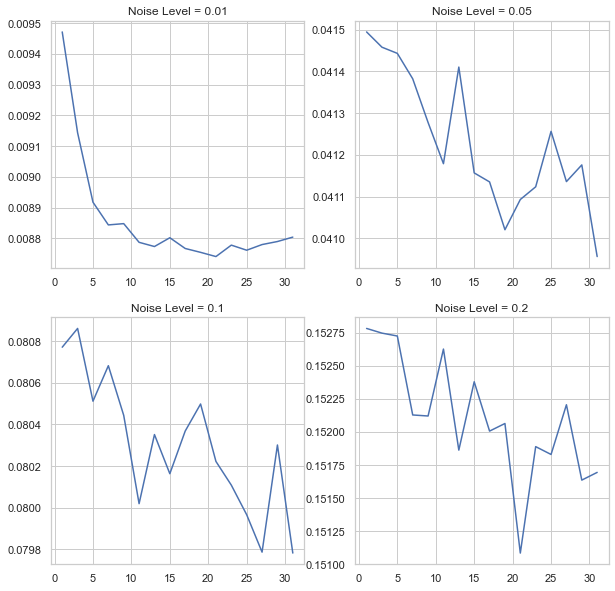

In [23]:
# Average rmse for each noise level, by K value

## Condense to 1 value per unique noise_level-neighbors value
avg_results = []
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
neighbors = np.linspace(1, 31, 16)
neighbors = [int(x) for x in neighbors]
for noise_level in noise_levels:
    for neighbor in neighbors:
        dat_temp = results.loc[(results['noise_level']==noise_level)&\
                               (results['neighbors']==neighbor)].copy()
        dat_temp.reset_index(inplace=True, drop=True)
        mean_val = np.mean(dat_temp['avg_rmse'].values)
        avg_results.append([noise_level, neighbor, mean_val])
avg_results = pd.DataFrame(avg_results,
                           columns=['noise_level', 'neighbors', 'mean_val'])

# Plot
fig, axs = plt.subplots(2, 2, figsize = (10,10))
# Noise Level 0.01
dat_temp = avg_results.loc[avg_results['noise_level']==0.01].copy()
axs[0, 0].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[0, 0].title.set_text('Noise Level = 0.01')
# Noise Level 0.05
dat_temp = avg_results.loc[avg_results['noise_level']==0.05].copy()
axs[0, 1].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[0, 1].title.set_text('Noise Level = 0.05')
# Noise Level 0.1
dat_temp = avg_results.loc[avg_results['noise_level']==0.1].copy()
axs[1, 0].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[1, 0].title.set_text('Noise Level = 0.1')
# Noise Level 0.2
dat_temp = avg_results.loc[avg_results['noise_level']==0.2].copy()
axs[1, 1].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[1, 1].title.set_text('Noise Level = 0.2')

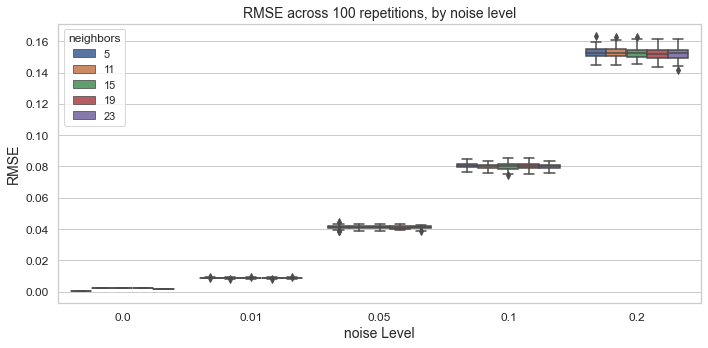

In [24]:
# Box Plots of select k values
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='neighbors',
            data = results.loc[results['neighbors'].isin([5,11,15,19,23])])
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("RMSE",
              fontsize=14)
ax.set_title("RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

## c) Random Forest Regressor

In [25]:
# Initialize result array
results = []

# Define alphas
model_parameters = [[500, 4, 40],
                    [500, 5, 40],
                    [500, 6, 40],
                    [1000, 4, 40],
                    [1000, 5, 40],
                    [1000, 6, 40],
                    [500, 4, 50],
                    [500, 5, 50],
                    [500, 6, 50],
                    [1000, 4, 50],
                    [1000, 5, 50],
                    [1000, 6, 50]]

model_num = 1
for model_params in model_parameters:
    model = RandomForestRegressor(n_estimators=model_params[0],
                                  max_features=model_params[1],
                                  max_depth=model_params[2])
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         Hb_dat['signal'].values, 
                                                         HbO2_dat['signal'].values, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, model_num])
    
    model_num+=1

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 
                                  'rep', 
                                  'avg_rmse', 
                                  'model_num'])
results

,noise_level,rep,avg_rmse,model_num
0,0.0,1.0,0.001015,1
1,0.0,2.0,0.001015,1
2,0.0,3.0,0.001015,1
3,0.0,4.0,0.001015,1
4,0.0,5.0,0.001015,1
...,...,...,...,...
5995,0.2,96.0,0.161873,12
5996,0.2,97.0,0.163536,12
5997,0.2,98.0,0.154760,12
5998,0.2,99.0,0.156297,12


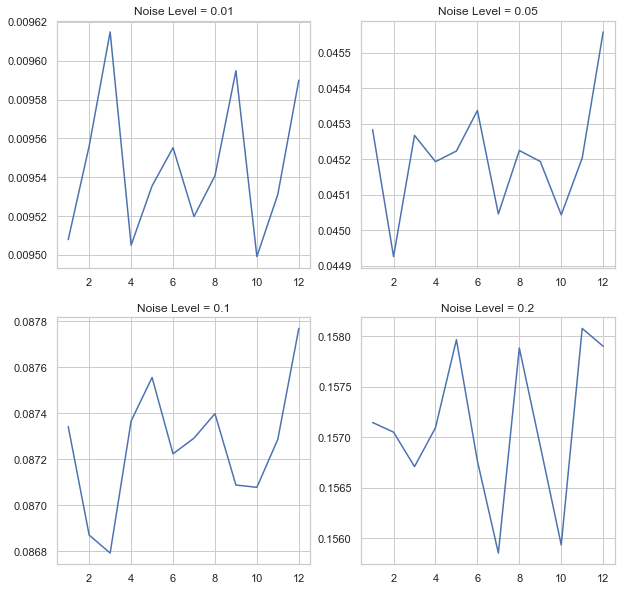

In [26]:
# Average rmse for each noise level, by model value

## Condense to 1 value per unique noise_level-model value
avg_results = []
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
models = range(1, len(model_parameters)+1)
for noise_level in noise_levels:
    for model_num in models:
        dat_temp = results.loc[(results['noise_level']==noise_level)&\
                               (results['model_num']==model_num)].copy()
        dat_temp.reset_index(inplace=True, drop=True)
        mean_val = np.mean(dat_temp['avg_rmse'].values)
        avg_results.append([noise_level, model_num, mean_val])
avg_results = pd.DataFrame(avg_results,
                           columns=['noise_level', 'model_num', 'mean_val'])

# Plot
fig, axs = plt.subplots(2, 2, figsize = (10,10))
# Noise Level 0.01
dat_temp = avg_results.loc[avg_results['noise_level']==0.01].copy()
axs[0, 0].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[0, 0].title.set_text('Noise Level = 0.01')
# Noise Level 0.05
dat_temp = avg_results.loc[avg_results['noise_level']==0.05].copy()
axs[0, 1].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[0, 1].title.set_text('Noise Level = 0.05')
# Noise Level 0.1
dat_temp = avg_results.loc[avg_results['noise_level']==0.1].copy()
axs[1, 0].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[1, 0].title.set_text('Noise Level = 0.1')
# Noise Level 0.2
dat_temp = avg_results.loc[avg_results['noise_level']==0.2].copy()
axs[1, 1].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[1, 1].title.set_text('Noise Level = 0.2')

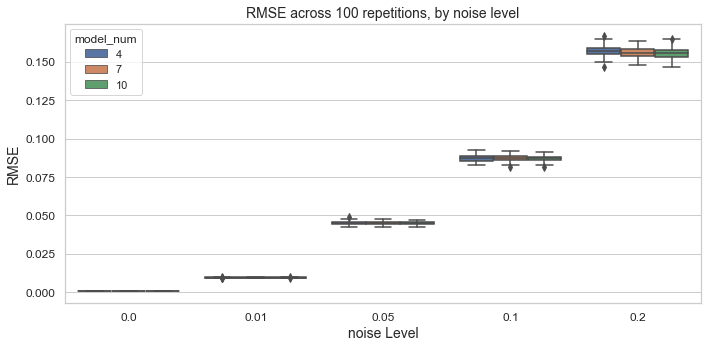

In [27]:
# Box Plots of select k values
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='model_num',
            data = results.loc[results['model_num'].isin([4,7,10])])
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("RMSE",
              fontsize=14)
ax.set_title("RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

# IV. results of best models on plot

In [10]:
# Training dataset
train_dataset = create_simulated_dataset(fractional_components, 
                                         Hb_dat['signal'].values, 
                                         HbO2_dat['signal'].values, 
                                         0)
train_dataset

,y1,y2,x1,x2,x3,x4,x5,x6
0,0.000,1.0,0.105222,0.111896,0.151551,0.232430,0.312525,0.414213
1,0.001,1.0,0.106222,0.112604,0.152002,0.233029,0.312830,0.414481
2,0.002,1.0,0.107222,0.113312,0.152452,0.233628,0.313135,0.414749
3,0.003,1.0,0.108222,0.114020,0.152903,0.234227,0.313441,0.415017
4,0.004,1.0,0.109222,0.114728,0.153354,0.234825,0.313746,0.415285
...,...,...,...,...,...,...,...,...
996,0.996,0.0,0.996000,0.705060,0.448923,0.596349,0.304236,0.267086
997,0.997,0.0,0.997000,0.705768,0.449374,0.596947,0.304541,0.267354
998,0.998,0.0,0.998000,0.706476,0.449825,0.597546,0.304846,0.267622
999,0.999,0.0,0.999000,0.707184,0.450276,0.598145,0.305152,0.267890


In [11]:
# Define X for spectral-unmixing
y1_100 = np.squeeze(train_dataset.iloc[len(train_dataset)-1,
                                       2:].to_numpy())
y2_100 = np.squeeze(train_dataset.iloc[0,
                                       2:].to_numpy())

X_unmixing = np.array([y1_100, y2_100]).T
X_unmixing

array([[1.        , 0.10522183],
       [0.70789164, 0.11189635],
       [0.45072634, 0.15155084],
       [0.59874362, 0.23243031],
       [0.3054574 , 0.31252454],
       [0.26815862, 0.4142128 ]])

In [12]:
# Define X for machine learning
X_ml = train_dataset.iloc[:, 2:].values
X_ml

array([[0.10522183, 0.11189635, 0.15155084, 0.23243031, 0.31252454,
        0.4142128 ],
       [0.10622183, 0.11260424, 0.15200157, 0.23302905, 0.31283   ,
        0.41448096],
       [0.10722183, 0.11331213, 0.1524523 , 0.2336278 , 0.31313545,
        0.41474912],
       ...,
       [0.998     , 0.70647585, 0.44982489, 0.59754613, 0.30484649,
        0.2676223 ],
       [0.999     , 0.70718375, 0.45027562, 0.59814488, 0.30515194,
        0.26789046],
       [1.        , 0.70789164, 0.45072634, 0.59874362, 0.3054574 ,
        0.26815862]])

In [13]:
# Define y for machine learning
y_ml = train_dataset.iloc[:, 0:2].values
y_ml

array([[0.   , 1.   ],
       [0.001, 1.   ],
       [0.002, 1.   ],
       ...,
       [0.998, 0.   ],
       [0.999, 0.   ],
       [1.   , 0.   ]])

In [14]:
# Train models
ridge_model = Ridge(positive=True, alpha=1).fit(X_ml, y_ml)
knn_model = KNeighborsRegressor(n_neighbors=27).fit(X_ml, y_ml)
RFR_model = RandomForestRegressor(n_estimators=500,
                                  max_features=4,
                                  max_depth=50).fit(X_ml, y_ml)

In [15]:
# Define model for spectral unmixing
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

In [16]:
# Initialize result array
results = []

# Define noise levels
noise_levels = np.linspace(0,.2,21)
for noise_level in noise_levels:
    
    # Define number of repetitions
    reps = np.linspace(1, 100, 100)
    for rep in reps:
        
        ## 1) Create Simulated Dataset
        
        # Create simulated dataset
        simulated_dataset = create_simulated_dataset(fractional_components, 
                                                     Hb_dat['signal'].values, 
                                                     HbO2_dat['signal'].values, 
                                                     noise_level)
        
        # Define actual y1s and y2s
        y1s = list(simulated_dataset['y1'].values)
        y2s = list(simulated_dataset['y2'].values)
        
        ## 2) Spectral unmixing

        # Preallocate lists to hold y1 and y2 estimates
        y1_estimates = []
        y2_estimates = []

        # Loop through each spectrum and estimate y1 and y2 using spectral unmixing
        for spectrum_iterator in range(len(simulated_dataset)):
            y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                                  2:].to_numpy())
            # Use spectral unmixing to get fractional components
            linear_regressor.fit(X_unmixing, y)

            # Estimated fractional components (y1_frac, y2_frac)
            y1_estimate, y2_estimate = linear_regressor.coef_
    
            # Append results
            y1_estimates.append(y1_estimate)
            y2_estimates.append(y2_estimate)
    
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
            
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
            
        # Append result
        results.append(['spectral-unmixing', noise_level, rep, avg_rmse])
        
        ## 3) Ridge Regression
        
        # Estimated y1s and y2s
        yhat = ridge_model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
        
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
        
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
        
        # Append result
        results.append(['ridge-regression', noise_level, rep, avg_rmse])
        
        ## 4) KNN
        
        # Estimated y1s and y2s
        yhat = knn_model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
        
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
        
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
        
        # Append result
        results.append(['knn', noise_level, rep, avg_rmse])
        
        ## 5) RFR
        
        # Estimated y1s and y2s
        yhat = RFR_model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
        
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
        
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
        
        # Append result
        results.append(['random-forest', noise_level, rep, avg_rmse])
        

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['model', 'noise_level', 'rep', 'avg_rmse'])
results

,model,noise_level,rep,avg_rmse
0,spectral-unmixing,0.0,1.0,2.010949e-16
1,ridge-regression,0.0,1.0,5.313955e-02
2,knn,0.0,1.0,2.706043e-03
3,random-forest,0.0,1.0,1.015374e-03
4,spectral-unmixing,0.0,2.0,2.010949e-16
...,...,...,...,...
8395,random-forest,0.2,99.0,1.570483e-01
8396,spectral-unmixing,0.2,100.0,2.636140e-01
8397,ridge-regression,0.2,100.0,5.271389e-01
8398,knn,0.2,100.0,1.489665e-01


In [17]:
# Median RMSE for each model type
models = ['spectral-unmixing', 'ridge-regression', 'knn', 'random-forest']
table_results = []
for noise_level in noise_levels:
    row_result = []
    row_result.append(noise_level)
    for model in models:
        dat_temp = results.loc[(results['model']==model)&\
                               (results['noise_level']==noise_level)].copy()
        dat_temp.reset_index(inplace=True, drop=True)
        median_val = np.median(dat_temp['avg_rmse'])
        row_result.append(np.round(median_val,4))
    table_results.append(row_result)

table_results = pd.DataFrame(table_results,
                             columns = ['noise-level'] + models)
table_results

,noise-level,spectral-unmixing,ridge-regression,knn,random-forest
0,0.00,0.0000,0.0531,0.0027,0.0010
1,0.01,0.0153,0.0608,0.0088,0.0095
2,0.02,0.0303,0.0764,0.0169,0.0184
3,0.03,0.0454,0.0963,0.0249,0.0274
4,0.04,0.0600,0.1184,0.0331,0.0362
5,0.05,0.0743,0.1423,0.0411,0.0450
6,0.06,0.0889,0.1665,0.0491,0.0538
7,0.07,0.1028,0.1917,0.0568,0.0625
8,0.08,0.1165,0.2170,0.0650,0.0709
9,0.09,0.1306,0.2419,0.0720,0.0787


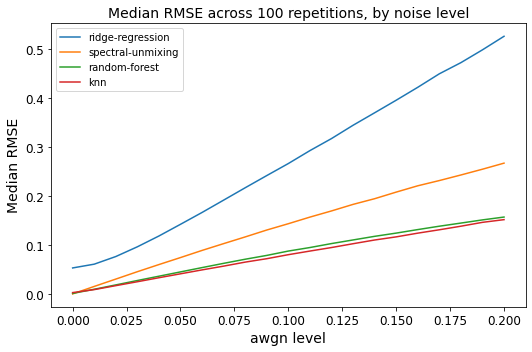

In [18]:
# Plot of table results
fig, ax = plt.subplots(figsize = (7.5,5))

## Define x
x = table_results['noise-level'].values

## Plot median for ridge-regression
ax.plot(x, table_results['ridge-regression'].values, 
        label = "ridge-regression")

## Plot median for spectral unmixing
ax.plot(x, table_results['spectral-unmixing'].values, 
        label = "spectral-unmixing")

## Plot median for random-forest
ax.plot(x, table_results['random-forest'].values, 
        label = "random-forest")

## Plot median for knn
ax.plot(x, table_results['knn'].values, 
        label = "knn")

## Show legend
ax.legend()

## Additional Formatiing
ax.set_xlabel("awgn level",
              fontsize=14)
ax.set_ylabel("Median RMSE",
              fontsize=14)
ax.set_title("Median RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

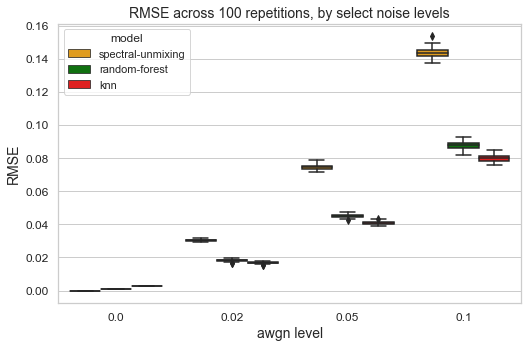

In [23]:
# Box Plot of result -- without ridge-regression
fig, ax = plt.subplots(figsize = (7.5,5))
sns.set(style="whitegrid")
noise_levels = [0.00, 0.02, 0.05, 0.1]
sns.boxplot(x='noise_level', 
            y='avg_rmse', 
            hue='model', 
            data = results.loc[(results['model']!='ridge-regression')&\
                               (results['noise_level'].isin(noise_levels))],
            hue_order = ['spectral-unmixing', 'random-forest', 'knn'],
            palette=["orange", "green", "red"])
ax.set_xlabel("awgn level",
              fontsize=14)
ax.set_ylabel("RMSE",
              fontsize=14)
ax.set_title("RMSE across 100 repetitions, by select noise levels",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()